Reference: https://pyro.ai/examples/stable.html  
Dataset: http://finance.yahoo.com

In [1]:
import torch
import numpyro
import numpy as np
import pandas as pd
import jax.numpy as jnp
import jax.scipy as jsp
import matplotlib.pyplot as plt
import numpyro.distributions as dist
import pandas_datareader.data as pdr

from scipy.fft import dct, next_fast_len
from jax import vmap, random
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
from utils import select_columns, samples_to_df, df_to_samples, plot_ESS, plot_GR, plot_posterior

numpyro.set_platform("cpu")
numpyro.set_host_device_count(32)

rng_key = random.PRNGKey(0)
rng_key_fit, rng_key_predict = random.split(rng_key)

num_chains = 5
num_samples = 2000

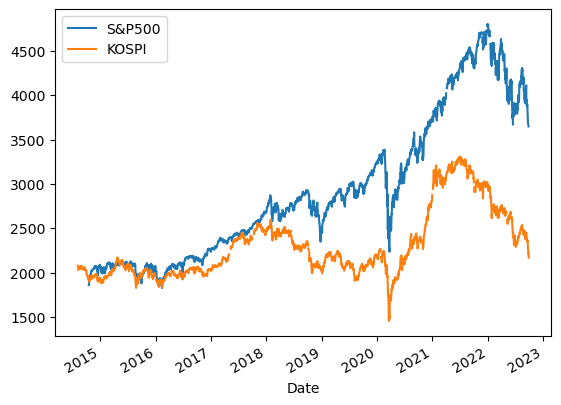

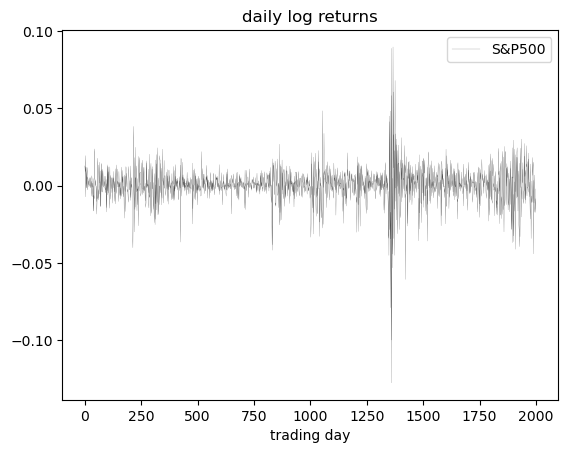

In [2]:
snp500 = pdr.get_data_yahoo("^GSPC", start="2014-01-01")["Close"][-2001:]
kospi = pdr.get_data_yahoo("^KS11", start="2014-01-01")["Close"][-2001:]
pd.DataFrame({"S&P500": snp500, "KOSPI": kospi}).plot()
plt.show()

r = np.log(snp500[1:].to_numpy() / snp500[:-1].to_numpy())
plt.plot(r, "k", lw=0.1, label="S&P500")
plt.title("daily log returns")
plt.xlabel("trading day")
plt.legend()
plt.show()

In [3]:
def model(r, obs=True):
    log_h_0 = numpyro.sample("log_h_0", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.LogNormal(0, 1))
    v = numpyro.sample("v", dist.Normal(0, 1).expand(r.shape).to_event(1))
    log_h = numpyro.deterministic("log_h", log_h_0 + sigma * v.cumsum(axis=-1))
    sqrt_h = numpyro.deterministic("sqrt_h", jnp.exp(log_h / 2))

    nu = numpyro.sample("nu", dist.Exponential(1e-1))
    r_loc = numpyro.sample("r_loc", dist.Normal(0, 1e-2))
    numpyro.sample("r", dist.StudentT(nu, r_loc * sqrt_h, sqrt_h).to_event(1), obs=r if obs else None)

def model_dct(r, obs=True):
    log_h_0 = numpyro.sample("log_h_0", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.LogNormal(0, 1))
    v_hat = numpyro.sample("v_hat", dist.Normal(0, 1).expand((len(r),)).to_event(1)) 
    v = numpyro.deterministic("v", jsp.fft.dct(v_hat, norm="ortho"))
    log_h = numpyro.deterministic("log_h", log_h_0 + sigma * v.cumsum(axis=-1))
    sqrt_h = numpyro.deterministic("sqrt_h", jnp.exp(log_h / 2))

    nu = numpyro.sample("nu", dist.Exponential(1e-1))
    r_loc = numpyro.sample("r_loc", dist.Normal(0, 1e-2))
    numpyro.sample("r", dist.StudentT(nu, r_loc * sqrt_h, sqrt_h).to_event(1), obs=r if obs else None)

In [24]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=num_samples, num_samples=num_samples, num_chains=num_chains)
mcmc.run(rng_key_fit, r)
mcmc.print_summary()
samples = mcmc.get_samples()
df_snp500 = samples_to_df(samples)
df_snp500.to_csv("result/stochastic_volatility_snp500.csv")

# kernel = NUTS(model_dct)
# mcmc = MCMC(kernel, num_warmup=num_samples, num_samples=num_samples, num_chains=num_chains)
# mcmc.run(rng_key_fit, r)
# mcmc.print_summary()
# samples_dct = mcmc.get_samples()
# df_snp500_dct = samples_to_df(samples_dct)
# df_snp500_dct.to_csv("result/stochastic_volatility_snp500_dct.csv")

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   log_h_0     -4.82      2.21     -5.64     -6.72     -0.60      2.71      3.49
        nu     19.01     12.48     18.10      2.63     34.08      5.35      1.36
     r_loc     -0.38      0.80      0.01     -1.98      0.03       nan    103.06
     sigma      0.47      0.37      0.30      0.26      1.22      2.51     16.46
      v[0]     -1.46      0.99     -1.40     -3.19     -0.27      8.96      1.17
      v[1]     -1.07      1.34     -1.26     -2.72      0.95      4.08      1.57
      v[2]     -1.25      0.93     -1.13     -2.91      0.02     15.68      1.09
      v[3]     -0.85      1.37     -1.07     -2.51      1.26      3.93      1.62
      v[4]     -0.78      1.29     -0.96     -2.41      1.14      4.20      1.54
      v[5]     -0.89      1.04     -0.90     -2.57      0.35      6.74      1.25
      v[6]     -0.49      1.50     -0.79     -2.24      1.94      3.58      1.77
      v[7]     -1.00      0

In [4]:
df_snp500 = pd.read_csv("result/stochastic_volatility_snp500.csv")
df_snp500_dct = pd.read_csv("result/stochastic_volatility_snp500_dct.csv")

samples = df_to_samples(
    df_snp500,
    params=["log_h_0", "sigma", "v", "log_h", "sqrt_h", "nu", "r_loc"],
    shapes=[(), (), (len(r),), (len(r),), (len(r),), (), ()]
)
samples_dct = df_to_samples(
    df_snp500_dct,
    params=["log_h_0", "sigma", "v_hat", "v", "log_h", "sqrt_h", "nu", "r_loc"],
    shapes=[(), (), (len(r),), (len(r),), (len(r),), (len(r),), (), ()]
)

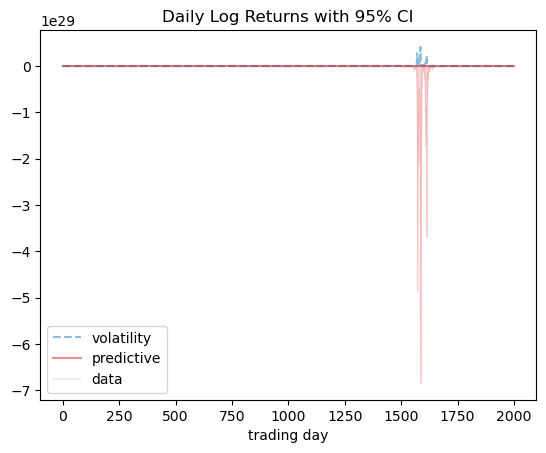

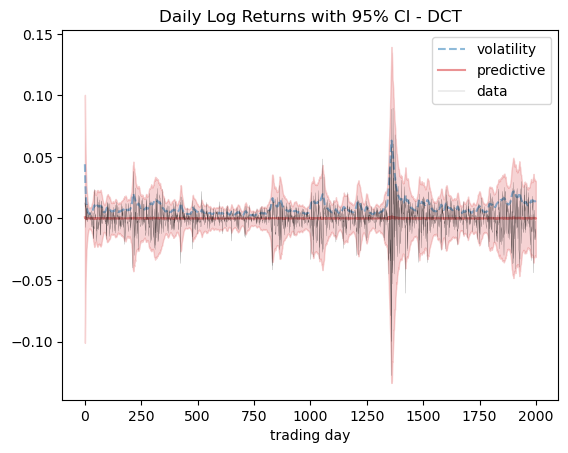

In [30]:
def predict(model, samples, rng_key, r, num_samples, num_chains):
    def _predict(samples, rng_key):
        _model = handlers.substitute(handlers.seed(model, rng_key), samples)
        _trace = handlers.trace(_model).get_trace(r, False)
        return _trace["r"]["value"]
    return vmap(_predict)(samples, random.split(rng_key, num_samples * num_chains))

predictions = predict(model, samples, rng_key_predict, r, num_samples, num_chains)
mid_prediction = np.median(predictions, axis=0)
low_prediction = np.percentile(predictions, 2.5, axis=0)
high_prediction = np.percentile(predictions, 97.5, axis=0)
mean_volatility = samples["sqrt_h"].mean(axis=0)

predictions_dct = predict(model_dct, samples_dct, rng_key_predict, r, num_samples, num_chains)
mid_prediction_dct = np.median(predictions_dct, axis=0)
low_prediction_dct = np.percentile(predictions_dct, 2.5, axis=0)
high_prediction_dct = np.percentile(predictions_dct, 97.5, axis=0)
mean_volatility_dct = samples_dct["sqrt_h"].mean(axis=0)

plt.plot(np.arange(len(r)), mean_volatility, color="tab:blue", alpha=0.5, linestyle="--", label="volatility")
plt.plot(np.arange(len(r)), mid_prediction, color="tab:red", alpha=0.5, label="predictive")
plt.fill_between(np.arange(len(r)), low_prediction, high_prediction, color="tab:red", alpha=0.2)
plt.plot(r, color="k", lw=0.1, label="data")
plt.title("Daily Log Returns with 95% CI")
plt.xlabel("trading day")
plt.legend()
plt.show()

plt.plot(np.arange(len(r)), mean_volatility_dct, color="tab:blue", alpha=0.5, linestyle="--", label="volatility")
plt.plot(np.arange(len(r)), mid_prediction_dct, color="tab:red", alpha=0.5, label="predictive")
plt.fill_between(np.arange(len(r)), low_prediction_dct, high_prediction_dct, color="tab:red", alpha=0.2)
plt.plot(r, color="k", lw=0.1, label="data")
plt.title("Daily Log Returns with 95% CI - DCT")
plt.xlabel("trading day")
plt.legend()
plt.show()

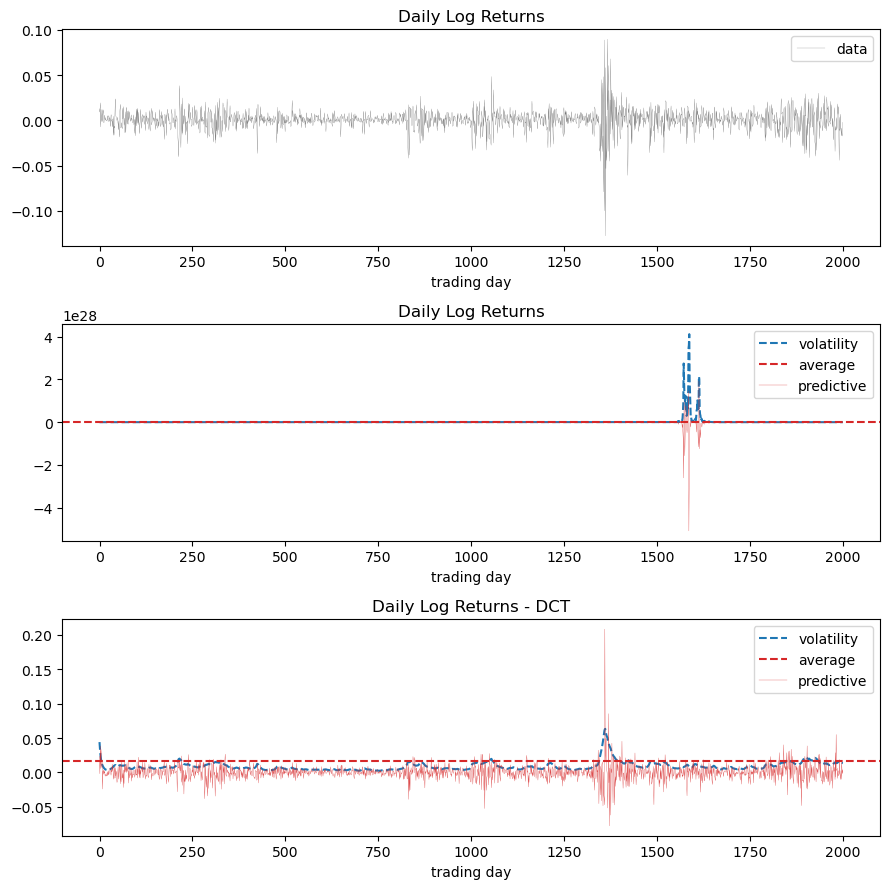

In [5]:
fig, axes = plt.subplots(3, 1, figsize=(9, 9))

axes[0].plot(r, color="k", lw=0.1, label="data")
axes[0].set_title("Daily Log Returns")
axes[0].set_xlabel("trading day")
axes[0].legend()

axes[1].plot(samples["sqrt_h"].mean(axis=0), color="tab:blue", linestyle="--", label="volatility")
axes[1].axhline(samples["r_loc"].mean(axis=0), color="tab:red", linestyle="--", label="average")
axes[1].plot(torch.distributions.StudentT(samples["nu"].mean(axis=0), samples["r_loc"].mean(axis=0), 1).sample((len(r),)) * samples["sqrt_h"].mean(axis=0), color="tab:red", lw=0.2, label="predictive")
axes[1].set_title("Daily Log Returns")
axes[1].set_xlabel("trading day")
axes[1].legend()

axes[2].plot(samples_dct["sqrt_h"].mean(axis=0), color="tab:blue", linestyle="--", label="volatility")
axes[2].axhline(samples_dct["r_loc"].mean(axis=0), color="tab:red", linestyle="--", label="average")
axes[2].plot(torch.distributions.StudentT(samples_dct["nu"].mean(axis=0), samples_dct["r_loc"].mean(axis=0), 1).sample((len(r),)) * samples_dct["sqrt_h"].mean(axis=0), color="tab:red", lw=0.2, label="predictive")
axes[2].set_title("Daily Log Returns - DCT")
axes[2].set_xlabel("trading day")
axes[2].legend()

plt.tight_layout()
plt.show()

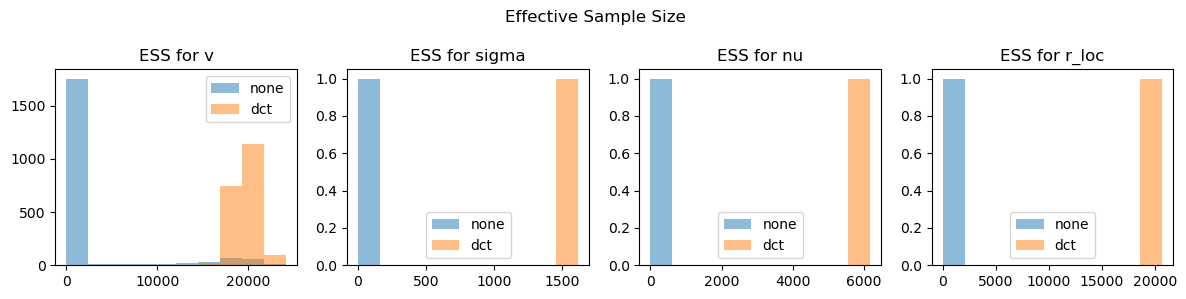

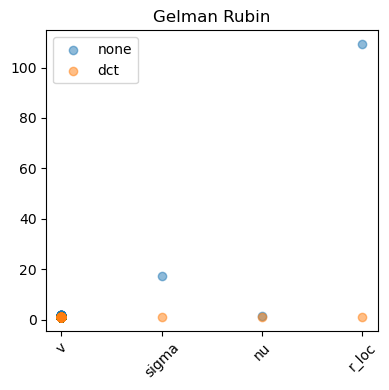

/home/sangho/anaconda3/envs/ppl/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
/home/sangho/anaconda3/envs/ppl/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


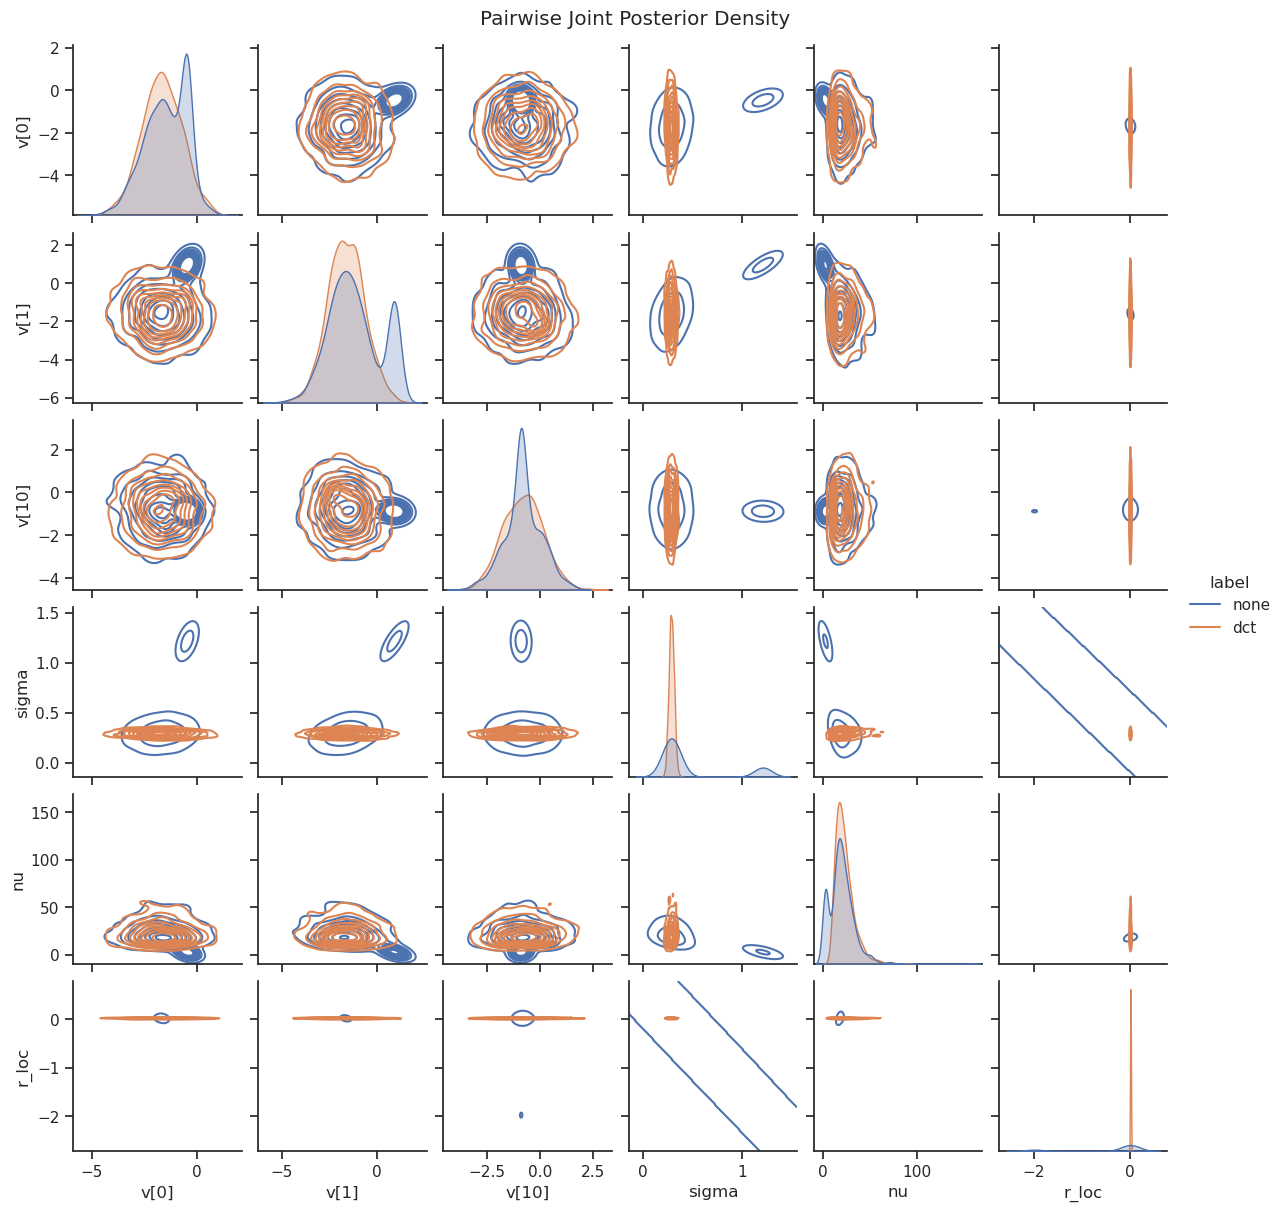

In [5]:
dfs = [df_snp500, df_snp500_dct]
labels = ["none", "dct"]

plot_ESS(dfs, labels,
         params=["v", "sigma", "nu", "r_loc"],
         num_chains=num_chains, num_samples=num_samples)

plot_GR(dfs, labels,
        params=["v", "sigma", "nu", "r_loc"],
        num_chains=num_chains, num_samples=num_samples)

plot_posterior(dfs, labels,
               params=["v[0]", "v[1]", "v[10]", "sigma", "nu", "r_loc"],
               num_subsamples=1000)